In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as sps
import scipy.special as spe
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/bioassay.txt', skip_blank_lines=False, header=8)
data.head()

,dose,n,y
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


# Ensayo de toxicidad, otra vez

Primero, normalizemos la log-dosis a media cero y desviación estándar de $0.5$:

In [3]:
xn = data['dose']
xn = 0.5 * (xn - np.mean(xn)) / np.std(xn)

Definamos varios posibles modelos:

In [4]:
m1 = pm.Model()
with m1:
    alpha = pm.Flat('alpha')
    beta  = pm.Flat('beta')
    theta = pm.math.invlogit(alpha + beta * xn)
    y     = pm.Binomial('y', p=theta, n=data['n'], observed=data['y'])
    LD50  = pm.Deterministic('LD50', -alpha/beta)
    
m2 = pm.Model()
with m2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta  = pm.Normal('beta',  mu=0, sd=10)
    theta = pm.math.invlogit(alpha + beta * xn)
    y     = pm.Binomial('y', p=theta, n=data['n'], observed=data['y'])
    LD50  = pm.Deterministic('LD50', -alpha/beta)
    
m3 = pm.Model()
with m3:
    alpha = pm.Cauchy('alpha', alpha=0, beta=10)
    beta  = pm.Cauchy('beta',  alpha=0, beta=2.5)
    theta = pm.math.invlogit(alpha + beta * xn)
    y     = pm.Binomial('y', p=theta, n=data['n'], observed=data['y'])
    LD50  = pm.Deterministic('LD50', -alpha/beta)
    
m1.name = 'm1'
m2.name = 'm2'
m3.name = 'm3'

## Estimadores puntuales

Hemos obtenido estimadores probabilísticos de los parámetros del modelo.  Todavía no hemos considerado si las suposiciones que hemos hecho hasta ahora son adecuadas.  Antes de eso, vale la pena comparar los resultados de la calibración Bayesiana contra otros estimadores de parámetros.

### Estimador de máxima verosimilitud (MLE)

El MLE corresponde al valor de los parámetros que maximiza la verosimilitud:
\begin{equation*}
\theta_{\mathrm{MLE}} = \operatorname{\arg\,\max}_\theta p(y \mid \theta, x)
\end{equation*}

### Estimador de máxima densidad posterior (MAP)

El MAP corresponde al valor de los parámetros que maximiza la distribución posterior, i.e., el modo de la distribución posterior:
\begin{equation*}
\theta_{\mathrm{MAP}} = \operatorname{\arg\,\max} p(\theta \mid y, x)
\end{equation*}
Dado que el denominador en el teorema de Bayes es independiente de $\theta$, tenemos que el MAP maximiza el numerador:
\begin{equation*}
\theta_{\mathrm{MAP}} = \operatorname{\arg\,\max} p(y \mid \theta, x) p(\theta)
\end{equation*}

Comparando contra el MLE, se ve que el MAP se diferencia en incluir la distribución anterior.  Para distribuciones anteriores uniformes o impropias, el MAP y el MLE coinciden.

Para nuestro ejemplo, usaremos la capacidad de calcular el MAP para calcular el MLE:

In [5]:
def mapc(model):
    with model:
        mapest = pm.find_MAP()
        print('\n', '{} MAP = '.format(model.name), mapest, '\n')

for m in [m1, m2, m3]:
    mapc(m);

/Users/bara947/.local/intelpython3/envs/u18fest_env/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.9824, ||grad|| = 0.00081433: 100%|██████████| 14/14 [00:00<00:00, 2652.94it/s]  



 m1 MAP =  {'alpha': array(-0.08327912), 'beta': array(8.860161), 'LD50': array(0.00939928)} 



/Users/bara947/.local/intelpython3/envs/u18fest_env/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -8.7372, ||grad|| = 7.2687e-05: 100%|██████████| 13/13 [00:00<00:00, 2878.73it/s]  
/Users/bara947/.local/intelpython3/envs/u18fest_env/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')



 m2 MAP =  {'alpha': array(-0.13128076), 'beta': array(7.16481409), 'LD50': array(0.01832298)} 



logp = -9.4974, ||grad|| = 3.1024e-06: 100%|██████████| 12/12 [00:00<00:00, 3149.67it/s]  


 m3 MAP =  {'alpha': array(-0.20565752), 'beta': array(4.76492768), 'LD50': array(0.04316068)} 



## Chequeo del modelo

Ahora podemos considerar la pregunta de si las suposiciones que hemos hecho son adecuadas para modelar los datos.  Para ésto utilizaremos las estrategias de simular replicaciones y de chequeo de la predicción posterior.

### Simular repeticiones

La verosimilitud $p(y \mid \theta, x)$ indica la distribución de las posibles observaciones dados los parámetros.  Entonces, una vez se han calibrado los parámetros podemos utilizar ésta verosimilitud para simular qué otras observaciones serían posibles o pudieron haber sido observadas.  Dado que nuestra calibración es probabilística, tenemos qué considerar la distribución posterior de los parámetros.  Si denotamos con $y^\mathrm{rep}$ las repeticiones, entonces
\begin{equation*}
p(y^\mathrm{rep} \mid y, x) = \int p(y^\mathrm{rep} \mid \theta, x) p(\theta \mid y, x) \, \mathrm{d} \theta
\end{equation*}
donde hemos marginalizado sobre $\Theta$

In [6]:
ml = [m1, m2, m3]
nm = len(ml)
tl = [None] * nm
for i in range(nm):
    tl[i] = pm.sample(2000, model=ml[i], tune=1000, target_accept=0.98, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4585.96draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3782.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:03<00:00, 3425.39draws/s]


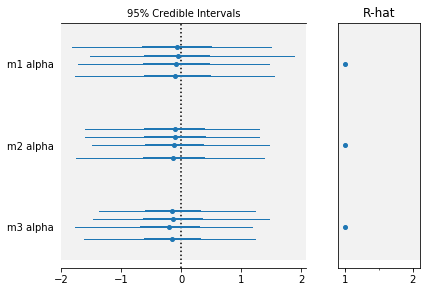

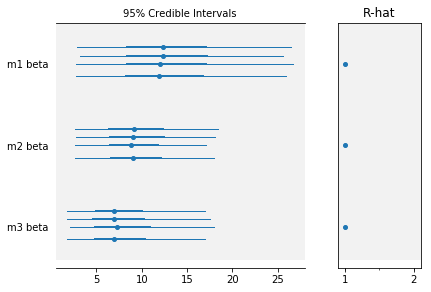

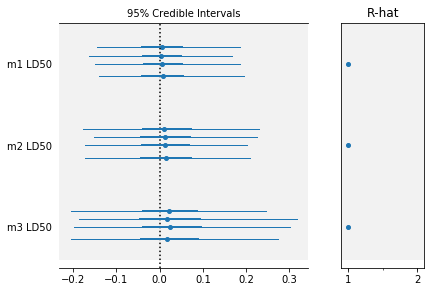

(<matplotlib.gridspec.GridSpec at 0xb2e4862b0>, None)

In [23]:
pm.forestplot(tl, [m1.name, m2.name, m3.name], varnames=['alpha']), plt.show()
pm.forestplot(tl, [m1.name, m2.name, m3.name], varnames=['beta']), plt.show()
pm.forestplot(tl, [m1.name, m2.name, m3.name], varnames=['LD50']), plt.show()

100%|██████████| 100/100 [00:00<00:00, 929.96it/s]


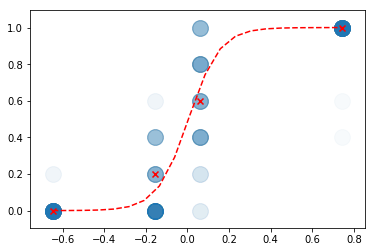

100%|██████████| 100/100 [00:00<00:00, 1118.50it/s]


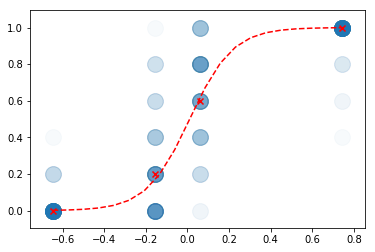

100%|██████████| 100/100 [00:00<00:00, 1240.62it/s]


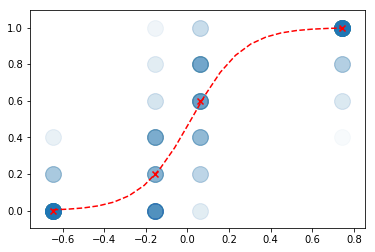

In [7]:
nppc = 100
xr   = np.linspace(xn.min(), xn.max(), 20)
for j in range(nm):
    ppc = pm.sample_posterior_predictive(tl[j], samples=nppc, model=ml[j])
    alpha = np.mean(tl[j]['alpha'])
    beta = np.mean(tl[j]['beta'])
    plt.plot(xr, spe.expit(alpha + beta * xr), 'r--')
    plt.scatter(np.tile(xn, (nppc, 1)), ppc['y'] / 5, alpha=0.03, s=250)
    plt.scatter(xn, data['y'] / data['n'], color='r', marker='x')
    plt.show()

## Evaluación y comparación de modelos

Digamos que se obtiene una observación nueva $(\hat{x}, \hat{y})$.  Podemos evaluar la calidad de nuestros modelos calculando la verosimilitud de ésta observación dada el modelo calibrado:
\begin{equation*}
p(\hat{y} \mid \hat{x}, y, x) = \int p(\hat{y} \mid \hat{x}, \theta) \, p(\theta \mid y, x) \, \mathrm{d} \theta
\end{equation*}
Llamamos a ésta distribución la _distribución predictiva_.

En general, queremos evaluar nuestros modelos sin adquirir nuevas observaciones.  Si los datos $(\hat{x}, \hat{y})$ vienen de la distribución $f(\hat{x}, \hat{y})$, podemos evaluar la esperanza de la log-distribución predictiva, o $\mathrm{elpd}$:
\begin{equation*}
\operatorname{elpd} = \int \log p(\hat{y} \mid \hat{x}, y, x) \, f(\hat{y}, \hat{x}) \, \mathrm{d} \hat{y} \mathrm{d} \hat{x},
\end{equation*}
pero desafortunadamente no conocemos $f(\hat{x}, \hat{y})$ _a priori_, así que ésta expresión debe aproximarse.

Los _criterios de información (IC)_ son estimadores que aproximan la log-distribuciónón predictiva. Dada una colección de modelos, éstos criterios se pueden utilizar para comparar los modelos entre ellos.  Por convención preferimos el modelo con menor valor del criterio en cuestión.

In [25]:
pm.compare({m1:tl[0], m2:tl[1], m3:tl[2]}, ic='WAIC')

/Users/bara947/.local/intelpython3/envs/u18fest_env/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
m2,6.25,0.53,0,1,2.77,0,0
m3,6.78,0.66,0.53,0,2.46,0.31,0
m1,7.93,1.22,1.68,0,3.75,1.1,1
